In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler


np.random.seed(42) # 乱数生成用のシードを設定
ite = 1 # 乱数生成の回数

random_seed = np.random.randint(0, 10000, ite)  # ランダムな整数値をシード値として取得.例えば 0 〜 9999 の間の整数をite個生成
print("random_seed", random_seed) # 乱数シード値の確認


random_seed [7270]


In [3]:
##################################################################

# 時間埋め込み（正弦波位置エンコーディング）
def pos_encoding(timesteps, output_dim, device='cpu'):
    position = timesteps.view(-1, 1).float()  # 必要に応じて型変換
    div_term = torch.exp(torch.arange(0, output_dim, 2, device=device, dtype=torch.float32) * 
                         (-np.log(10000.0) / output_dim))
    sinusoid = torch.cat([torch.sin(position * div_term), torch.cos(position * div_term)], dim=1)
    return sinusoid

# Dropoutの導入: 過学習を防ぐために、各隠れ層にnn.Dropoutを追加。
# Batch Normalizationの導入: 学習を安定させるためにnn.BatchNorm1dを適用。
# 活性化関数の選択: F.reluの代わりにnn.LeakyReLUやnn.ELUを試すことで、勾配消失問題に対応。

# 拡散モデル
class DiffusionModel(nn.Module):
    def __init__(self, time_embed_dim=16):
        super(DiffusionModel, self).__init__()
        self.time_embed_dim = time_embed_dim  # time_embed_dimをインスタンス変数として初期化
        self.fc1 = nn.Linear(2 + time_embed_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x, t):
        # 時間埋め込み
        t_embed = pos_encoding(t, self.time_embed_dim, x.device)
        x_t = torch.cat([x, t_embed], dim=-1)  # 時間情報と入力データを結合
        x_t = F.relu(self.fc1(x_t))
        x_t = F.relu(self.fc2(x_t))
        return self.fc3(x_t)

# 拡散プロセス
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        t_idx = t - 1 # alphas[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)  # (N, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        
        t_idx = t - 1 # alphas[0] is for t=1
        alpha = self.alphas[t_idx].view(-1, 1)
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)
        model.eval()
        with torch.no_grad():
            eps = model(x, t)

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps) / torch.sqrt(alpha)

        return mu

############################################
Data_Set_1, Seed: 7270
拡散ステップ数: 2000, 学習エポック数: 10, 学習率: 0.001
############################################
data.shape (500, 2)


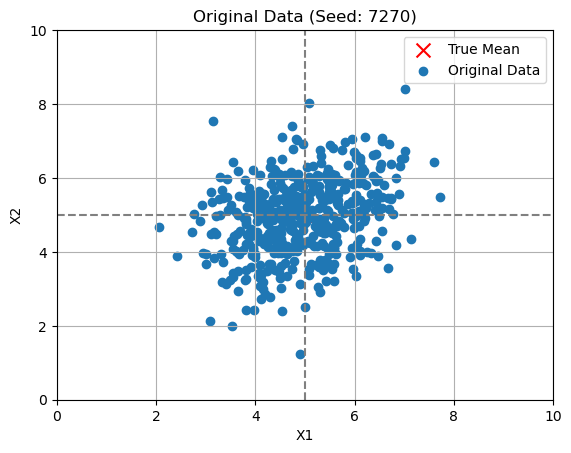

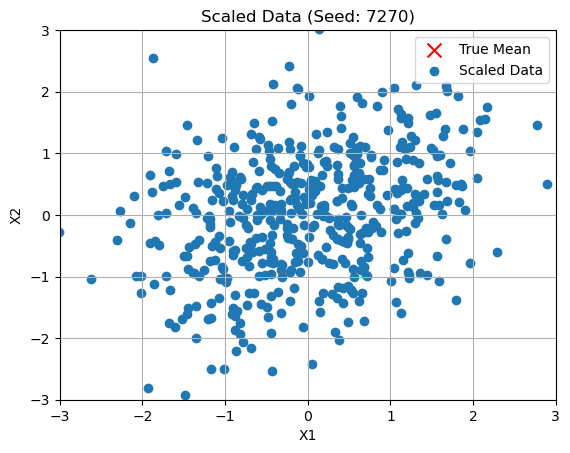

dataの平均ベクトル [4.94219657 4.96119013]
dataの分散共分散行列 [[0.92236249 0.30566806]
 [0.30566806 1.02858551]]
dataの相関係数 [[1.         0.31381887]
 [0.31381887 1.        ]]
Epoch 5, Loss: 0.2091571168601513
Epoch 10, Loss: 0.20451641824096442
学習終了


学習時間: 0.33秒


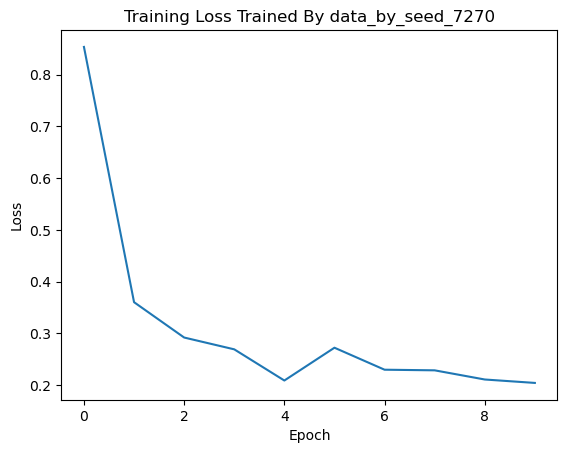



##################################################




In [ ]:
###################################################################

# 2次元正規分布の平均ベクトルと共分散行列を設定
original_mean = [5, 5]  # 平均ベクトル
original_cov = [[1, 0.3], [0.3, 1]]  # 共分散行列（相関あり）

# データセットサイズとデータセット数
num_dataset = 1000 # サンプリング回数
dataset_size = 500 # 元データのサイズ 


# ハイパーパラメータ
num_timesteps = 2000 # 拡散ステップ数
epochs = 10          # 学習エポック数
lr = 1e-3         # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# シード値の固定
np.random.seed(42)

# サンプリング
iter = 1 #学習元データの数
# シード値の生成
random_seed = np.random.randint(0, 10000, iter)

# モデルとデータを管理する辞書
models = {}
original_datas = {}

for (i, seed) in enumerate(random_seed):
    start_time = time.time() # 計測開始

    # モデルの初期化
    time_embed_dim = 16
    model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    diffuser = Diffuser(num_timesteps=num_timesteps, device=device)

    # 学習データ(ガウスノイズ)
    print("############################################")
    print(f"Data_Set_{i+1}, Seed: {seed}") # 開始の合図

    print(f"拡散ステップ数: {num_timesteps}, 学習エポック数: {epochs}, 学習率: {lr}")
    print("############################################")
    np.random.seed(seed) # 取得した乱数を新しいシード値として設定
    data = np.random.multivariate_normal(original_mean, original_cov, size=dataset_size) # 学習元データの生成 (50, 2)
    # データの標準化
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data) # shape: (500, 2), dtype: float64

    print("data.shape", data.shape) # (50, 2)
    # PyTorchテンソルへ明示的に float32 で変換
    train_data = torch.tensor(scaled_data, dtype=torch.float32).to(device) # shape: (50, 2)

    # データローダー作成
    batch_size = 10
    # モデル学習に使う DataLoader も float32 のテンソルから作成
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


    # 原点を基準として赤十字
    plt.axhline(original_mean[0], color='gray', linestyle='--')
    plt.axvline(original_mean[1], color='gray', linestyle='--')
    plt.scatter(original_mean[0], original_mean[1], color='red', marker='x', s=100, label='True Mean')
    # データの可視化
    plt.scatter(data[:, 0], data[:, 1], label='Original Data')
    plt.title(f'Original Data (Seed: {seed})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.grid()
    plt.show()

    # 標準化したデータの可視化
    plt.scatter(scaled_data[:, 0], scaled_data[:, 1], label='Scaled Data')
    plt.title(f'Scaled Data (Seed: {seed})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.grid()
    plt.show()

    # データの要約
    print("dataの平均ベクトル", np.mean(data, axis=0)) # 平均ベクトル
    print("dataの分散共分散行列", np.cov(data.T)) # 分散共分散行列
    print("dataの相関係数", np.corrcoef(data.T)) # 相関係数

    # 学習
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        for batch in dataloader:
            optimizer.zero_grad()
            x = batch.to(device)
            t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

            x_noisy, noise = diffuser.add_noise(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
        avg_loss = loss_sum / len(dataloader)
        losses.append(avg_loss)
        # 5の倍数エポックで損失を表示
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    # 辞書に保存
    models[f"model_{i+1}"] = model
    original_datas[f"seed_{seed}"] = data
    print("学習終了")
    end_time = time.time() # 計測終了
    print('\n')
    print(f"学習時間: {end_time - start_time:.2f}秒")

    # 学習曲線のプロット
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Trained By data_by_seed_{}'.format(seed))
    plt.show()
    print('\n')
    print("#"*50)
    print('\n')

In [12]:
###################################################################


# 拡散モデルのサンプリング関数
from tqdm import tqdm


def generate_samples(model, n=dataset_size, B=num_dataset, device='cpu'):
    model.eval() # モデルを評価モードに設定
    with torch.no_grad(): # 勾配計算を無効化
        new_sample_list = [] # サンプルを格納するリスト
        for _ in tqdm(range(B)): # 進捗バーを表示
            torch.manual_seed(np.random.randint(0, 10000)) # ランダムシードを設定
            samples = torch.randn((n, 2), device=device) # サンプルを生成
            for t in range(num_timesteps, 0, -1): # 拡散ステップを逆に進める
                t_tensor = torch.full((n,), t, device=device, dtype=torch.long) # 時間情報をテンソルに変換
                samples = diffuser.denoise(model, samples, t_tensor) # ノイズ除去
            new_sample_list.append(samples.cpu().numpy()) # CPUに戻してnumpy配列に変換
        return np.array(new_sample_list)  # (B, n, 2) 


# ブートストラップサンプリングの実行
generated_data_list = []


# 拡散モデルによるサンプリング
for model_key, data, seed, selected_model in zip(original_datas.keys(), original_datas.values(), models.keys(), models.values()):
    print("-"*50)
    print("#"*50)
    print(f"Seed: {seed.split('_')[-1]}")
    print("サンプリング開始")

    start_time = time.time() # 計測開始
    generated_data = generate_samples(selected_model, n=dataset_size, B=num_dataset, device=device) # サンプリング実行
    generated_data_list.append(generated_data) # サンプルをリストに追加
    generated_data = np.array(generated_data) # numpy配列に変換
    print("generated_data.shape", generated_data.shape) # (1000, 50, 2)
    end_time = time.time() # 計測終了
    print("サンプリング終了")

    print(f"サンプリング時間: {end_time - start_time:.2f}秒")
    print(f"サンプリング時間: {(end_time - start_time)//60}分 {(end_time - start_time)%60}秒")

    # サンプルされたデータの保存
    # torch.save(generated_data, f"master_research/saved_data/sampled_data/sampled_data_{seed.split('_')[-1]}_epoch_{epochs}.pth")
    print("#"*50)


--------------------------------------------------
##################################################
Seed: 1
サンプリング開始


100%|██████████| 1000/1000 [2:05:43<00:00,  7.54s/it] 

generated_data.shape (1000, 500, 2)
サンプリング終了
サンプリング時間: 7543.76秒
サンプリング時間: 125.0分 43.75854825973511秒
##################################################


In [3]:
import numpy as np


In [5]:
# generated_data_list = np.array(generated_data_list) # (seed_num, 1000, 50, 2)
print("generated_data_list.shape", np.array(generated_data_list).shape) # (seed_num, 1000, 50, 2)


NameError: name 'generated_data_list' is not defined

In [14]:
print("generated_data_list[0].shape", generated_data_list[0].shape) # (1000, 50, 2)

generated_data_list[0].shape (1000, 500, 2)


In [15]:
# generated_data: shape (B, n, 2)
# scaler: 学習時に fit() 済の StandardScaler オブジェクト

generated_data = generated_data_list[0]

# 逆変換を適用
generated_data_original = np.array([
    scaler.inverse_transform(sample) for sample in generated_data
])  # shape: (B, n, 2)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


generated_data_original.shape (1000, 500, 2)
generated_data_originalの平均ベクトル [5.167153 4.993504]
generated_data_originalの分散共分散行列 [[6.52035982e-10 5.43893367e-10]
 [5.43893367e-10 4.74838223e-10]]
generated_data_originalの相関係数 [[1.         0.97747385]
 [0.97747385 1.        ]]


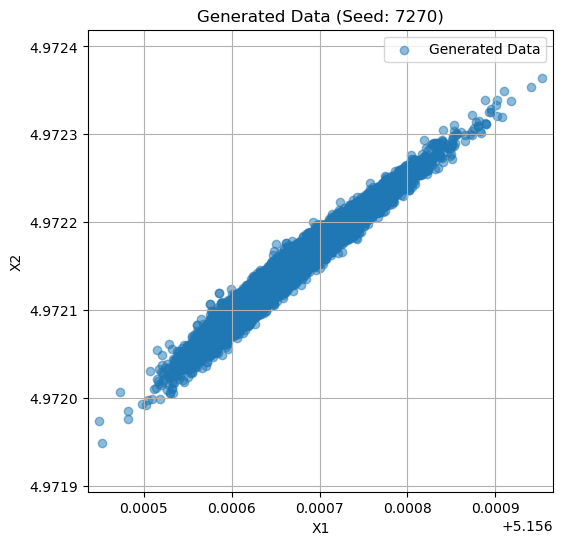

In [25]:
# generated_data_originalの平均・分散・相関係数・可視化
print("generated_data_original.shape", generated_data_original.shape) # (1000, 50, 2)
# 平均ベクトル
print("generated_data_originalの平均ベクトル", np.mean(generated_data_original, axis=(0, 1))) # 平均ベクトル
# 分散共分散行列
print("generated_data_originalの分散共分散行列", np.cov(generated_data_original.reshape(-1, 2).T)) # 分散共分散行列
# 相関係数
print("generated_data_originalの相関係数", np.corrcoef(generated_data_original.reshape(-1, 2).T)) # 相関係数


## 可視化
x_vals = generated_data_original[:, :, 0].flatten()
y_vals = generated_data_original[:, :, 1].flatten()

# 最小・最大 + 標準偏差から範囲を決定
x_min, x_max = x_vals.min(), x_vals.max()
y_min, y_max = y_vals.min(), y_vals.max()
x_std, y_std = x_vals.std(), y_vals.std()

k = 0.5  # 余白のスケール（標準偏差単位）

# プロット
plt.figure(figsize=(6, 6))
plt.scatter(x_vals, y_vals, alpha=0.5, label='Generated Data')
plt.title('Generated Data (Seed: {})'.format(random_seed[0]))
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid()
plt.axis('equal')

# 拡張された描画範囲
plt.xlim(x_min - k * x_std, x_max + k * x_std)
plt.ylim(y_min - k * y_std, y_max + k * y_std)

plt.show()

In [1]:
# 各データセットの平均ベクトルを計算
mean_vectors = np.mean(generated_data_original, axis=1)  # shape: (1000, 2)

# 可視化
plt.figure(figsize=(6, 6))
plt.scatter(mean_vectors[:, 0], mean_vectors[:, 1], alpha=0.5, color='blue', label='Mean of Each Set')
plt.title('Mean Vectors of Generated Data Sets')
plt.xlabel('Mean of X1')
plt.ylabel('Mean of X2')
plt.grid()
plt.axis('equal')
plt.legend()
plt.show()

NameError: name 'np' is not defined

############################################
Random Seed: 7270
############################################
平均ベクトルの平均: [0.22352935 0.01081093]
共分散行列の平均:
 [[7.08285962e-10 5.59500728e-10]
 [5.59500728e-10 4.62539216e-10]]
相関係数の平均: 0.9774389339931013


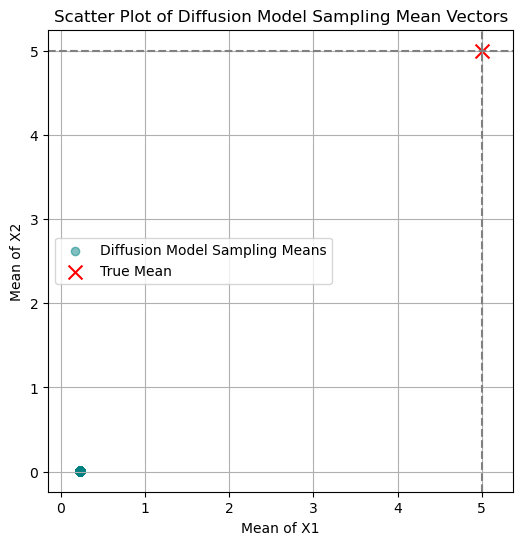

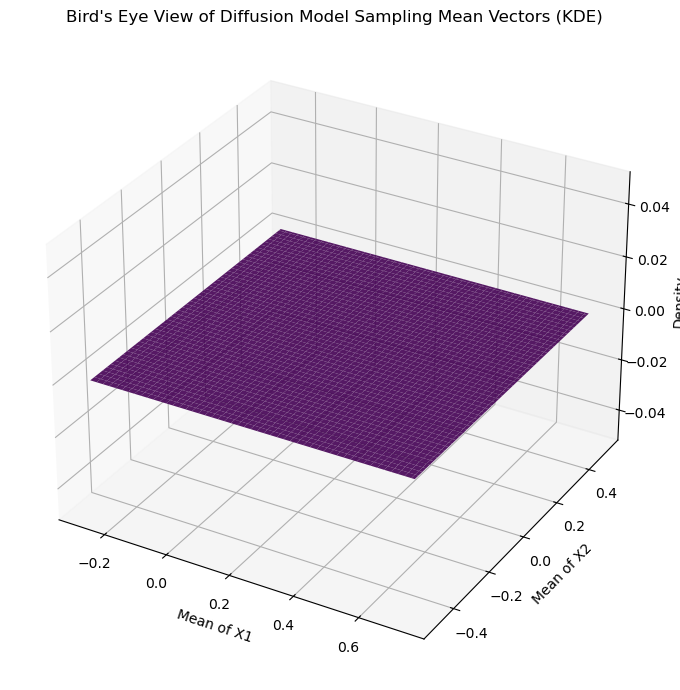

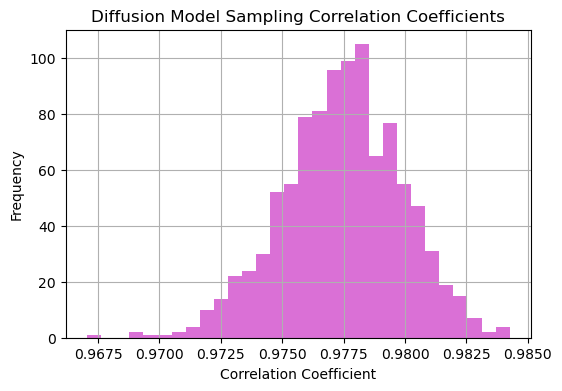

############################################
End
############################################




In [16]:
###################################################################


from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D  # 必要


# サンプリングの可視化
for seed, generated_samples in zip(np.nditer(random_seed), generated_data_list):
    print("############################################")
    print("Random Seed:", seed) # 開始の合図
    print("############################################")

    # ---------------------統計量制御---------------------
    generated_samples_mean_vecs = np.mean(generated_samples, axis=1) # 拡散モデルによるサンプルの平均ベクトル（1000, 2）
    generated_samples_cov_mats = np.array([np.cov(sample.T) for sample in generated_samples]) # 拡散モデルによるサンプルの共分散行列（1000, 2, 2）
    generated_samples_corr_coefs = np.array([np.corrcoef(sample.T)[0, 1] for sample in generated_samples]) # 拡散モデルによるサンプルの相関係数（1000,）

    # サイズの確認
    # print("Bootstrap Mean Vector", bootstrap_mean_vecs.shape) # 平均ベクトル
    # print("Bootstrap Covariance Matrix", bootstrap_cov_mats.shape) # 共分散行列
    # print("Bootstrap Correlation Coefficient", bootstrap_corr_coefs.shape) # 相関係数

    # 代表値を出力
    print("平均ベクトルの平均:", np.mean(generated_samples_mean_vecs, axis=0))
    print("共分散行列の平均:\n", np.mean(generated_samples_cov_mats, axis=0))
    print("相関係数の平均:", np.mean(generated_samples_corr_coefs))





    # 平均ベクトルの分布
    
    plt.figure(figsize=(6, 6))
    plt.scatter(generated_samples_mean_vecs[:, 0], generated_samples_mean_vecs[:, 1], alpha=0.5, color='teal', label='Diffusion Model Sampling Means')

    # 原点を基準として赤十字
    plt.axhline(original_mean[0], color='gray', linestyle='--')
    plt.axvline(original_mean[1], color='gray', linestyle='--')
    plt.scatter(original_mean[0], original_mean[1], color='red', marker='x', s=100, label='True Mean')

    plt.xlabel('Mean of X1')
    plt.ylabel('Mean of X2')
    plt.title('Scatter Plot of Diffusion Model Sampling Mean Vectors')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


    # カーネル密度推定
    kde = gaussian_kde(generated_samples_mean_vecs.T)

    # グリッド生成
    x = np.linspace(np.min(generated_samples_mean_vecs[:, 0]) - 0.5, np.max(generated_samples_mean_vecs[:, 0]) + 0.5, 100)
    y = np.linspace(np.min(generated_samples_mean_vecs[:, 1]) - 0.5, np.max(generated_samples_mean_vecs[:, 1]) + 0.5, 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(positions).reshape(X.shape)

    # 3Dプロット
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

    ax.set_xlabel('Mean of X1')
    ax.set_ylabel('Mean of X2')
    ax.set_zlabel('Density')
    ax.set_title('Bird\'s Eye View of Diffusion Model Sampling Mean Vectors (KDE)')
    plt.tight_layout()
    plt.show()




    # 相関係数の分布
    plt.figure(figsize=(6, 4))
    plt.hist(generated_samples_corr_coefs, bins=30, color='orchid')
    plt.title('Diffusion Model Sampling Correlation Coefficients')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()




    # 終了の合図
    print("############################################")
    print("End")
    print("############################################")

    # 改行
    print("\n")

In [13]:
print(generated_samples_mean_vecs[:, 0])

[2.2821178 2.5144827 2.3859575 2.4312427 2.0426717 2.09626   2.2964096
 1.9567354 2.482641  2.3756266 2.5294738 2.3434346 2.4066374 2.6055923
 2.0484803 2.45753   2.3372788 2.470073  2.3612468 2.5945275 2.643559
 2.4835768 2.6849103 1.953281  2.3389864 2.3593137 2.4885588 2.2006867
 2.3019216 2.5708764 1.9813899 2.6899853 2.604033  2.0908806 2.2585504
 2.0075583 2.2006357 2.2222786 2.5001442 2.4283454 2.4725685 2.2761822
 2.4279752 2.273914  2.0234687 2.2434108 2.4185107 2.14475   2.3706183
 2.4589748 2.2085419 2.4442778 2.2832956 2.5103447 2.502706  2.2966437
 2.3417737 2.4511764 2.3619175 2.5326343 2.440178  2.4358733 2.561394
 2.306461  2.3682613 2.473169  2.634326  2.4679792 2.3723855 2.4774256
 2.1134555 2.2058878 2.3176086 2.1737258 2.4405384 2.533852  2.530461
 2.4098718 2.0056129 2.0745528 2.017725  2.4684038 2.931948  2.1265914
 2.491183  2.3583093 2.387878  2.5630136 2.2466865 2.2418227 2.3500166
 2.2205667 2.3188725 2.3539083 2.331801  2.5374026 2.2664788 2.3603776
 2.143291

In [13]:
print(generated_samples_mean_vecs[:, 1])

[4.8228993 4.8236103 4.818172  4.828252  4.8225846 4.827217  4.823369
 4.825582  4.8231635 4.817591  4.823401  4.8215694 4.8178163 4.821711
 4.824209  4.8223    4.8231874 4.821705  4.825591  4.8233657 4.82151
 4.8210607 4.824083  4.822523  4.823911  4.8220096 4.8266106 4.818414
 4.812088  4.812176  4.820107  4.8191514 4.819658  4.8168187 4.8183613
 4.8216105 4.825641  4.8234897 4.8200755 4.8172674 4.822333  4.8311443
 4.8177643 4.821327  4.82331   4.82351   4.823286  4.817003  4.8179374
 4.8261027 4.818079  4.8158927 4.8241673 4.818322  4.8218293 4.820226
 4.8228364 4.823145  4.822888  4.8184347 4.8258305 4.821358  4.8175406
 4.825587  4.827058  4.8204308 4.8200264 4.8247266 4.823249  4.8204308
 4.8258486 4.829607  4.8181357 4.8211527 4.8199024 4.8223314 4.824854
 4.8209004 4.8193817 4.8213005 4.8214664 4.818875  4.821704  4.817008
 4.821053  4.8232465 4.8187385 4.8183413 4.826672  4.8264523 4.8215857
 4.8199654 4.829687  4.818391  4.817986  4.823853  4.82143   4.822858
 4.8264413 4.82

In [14]:
print(generated_samples_mean_vecs[0])

[4.537197  4.8228993]
